In [1]:
# ===============================================================
# CMSE 492 – Project: Predicting Exfoliation Energy of 2D Materials
# Author: Artemiy Filippov
# Notebook: materials_eda.ipynb
# Purpose: Data acquisition, exploratory analysis, and baseline model
# ===============================================================

# -----------------------------
# Imports
# -----------------------------
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matminer.datasets import load_dataset
from matminer.featurizers.structure import DensityFeatures
from matminer.featurizers.composition import ElementProperty

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# Directory setup
# -----------------------------
FIG_DIR = Path("../../figures")
DATA_DIR = Path("../../data")
PROC_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

for d in [FIG_DIR, PROC_DIR, RAW_DIR]:
    d.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid", context="talk")

In [2]:
# ===============================================================
# PART B1: Load Dataset
# ===============================================================

df = load_dataset("matbench_jdft2d")
print(f"✅ Dataset loaded successfully: {df.shape[0]} samples, {df.shape[1]} columns")
display(df.head())

print("""
Dataset: MatBench JDFT-2D (Ward et al., 2020)
Source: Materials Project via Matminer
Target property: Exfoliation energy (eV/atom)
""")

# Save small raw sample
df.sample(50, random_state=42).to_csv(PROC_DIR / "sample_raw.csv", index=False)

# ===============================================================
# PART B1: Feature Generation (Structure + Composition)
# ===============================================================

# Add composition column
df["composition"] = df["structure"].apply(lambda s: s.composition)

# Featurizers
density_feat = DensityFeatures()
magpie_feat = ElementProperty.from_preset("magpie")

# Apply featurization
df_feat = density_feat.featurize_dataframe(df.copy(), col_id="structure", ignore_errors=True)
df_feat = magpie_feat.featurize_dataframe(df_feat, col_id="composition", ignore_errors=True)

# Add target and clean
df_feat["exfoliation_en"] = df["exfoliation_en"].values
df_feat = df_feat.select_dtypes("number").dropna()

print("✅ Numeric features ready:", df_feat.shape)
display(df_feat.head())

# Save processed sample
df_feat.sample(50, random_state=0).to_csv(PROC_DIR / "sample_processed.csv", index=False)

✅ Dataset loaded successfully: 636 samples, 2 columns


,structure,exfoliation_en
0,"[[1.49323139 3.32688406 7.26257785] Hf, [3.326...",63.593833
1,"[[1.85068084 4.37698238 6.9301577 ] As, [0. ...",134.863750
2,"[[ 0. 2.0213325 11.97279555] Ti, [ 1...",43.114667
3,"[[2.39882726 2.39882726 2.53701553] In, [0.054...",240.715488
4,[[-1.83484554e-06 1.73300105e+00 2.61675943e...,67.442833



Dataset: MatBench JDFT-2D (Ward et al., 2020)
Source: Materials Project via Matminer
Target property: Exfoliation energy (eV/atom)



/opt/anaconda3/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


DensityFeatures:   0%|          | 0/636 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/636 [00:00<?, ?it/s]

✅ Numeric features ready: (635, 136)


,exfoliation_en,density,vpa,packing fraction,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,63.593833,3.021472,61.218660,0.177875,14.0,72.0,58.0,46.000000,21.333333,14.0,...,0.000000,0.000000,0.00000,0.0,152.0,227.0,75.0,191.000000,26.000000,152.0
1,134.863750,1.124487,110.637295,0.057581,33.0,33.0,0.0,33.000000,0.000000,33.0,...,0.000000,0.000000,0.00000,0.0,166.0,166.0,0.0,166.000000,0.000000,166.0
2,43.114667,1.385515,57.436271,0.108929,8.0,35.0,27.0,21.666667,9.111111,8.0,...,0.000023,0.000008,0.00001,0.0,12.0,194.0,182.0,90.000000,69.333333,12.0
3,240.715488,1.950268,137.847700,0.118812,49.0,83.0,34.0,66.000000,17.000000,49.0,...,0.000000,0.000000,0.00000,0.0,12.0,139.0,127.0,75.500000,63.500000,12.0
4,67.442833,1.183135,58.435112,0.083167,8.0,41.0,33.0,19.000000,14.666667,8.0,...,0.000000,0.000000,0.00000,0.0,12.0,229.0,217.0,84.333333,96.444444,12.0


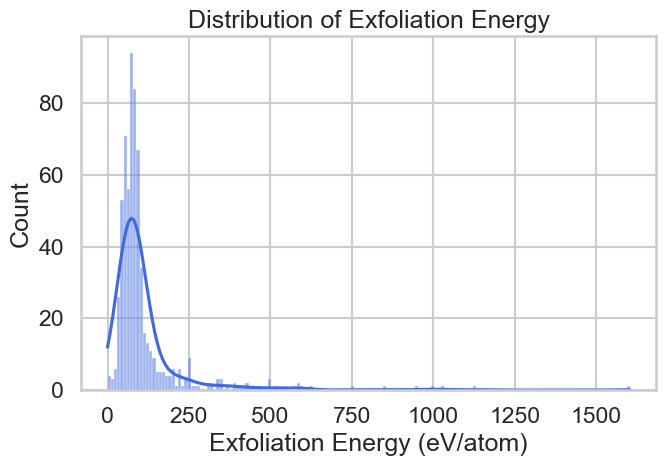

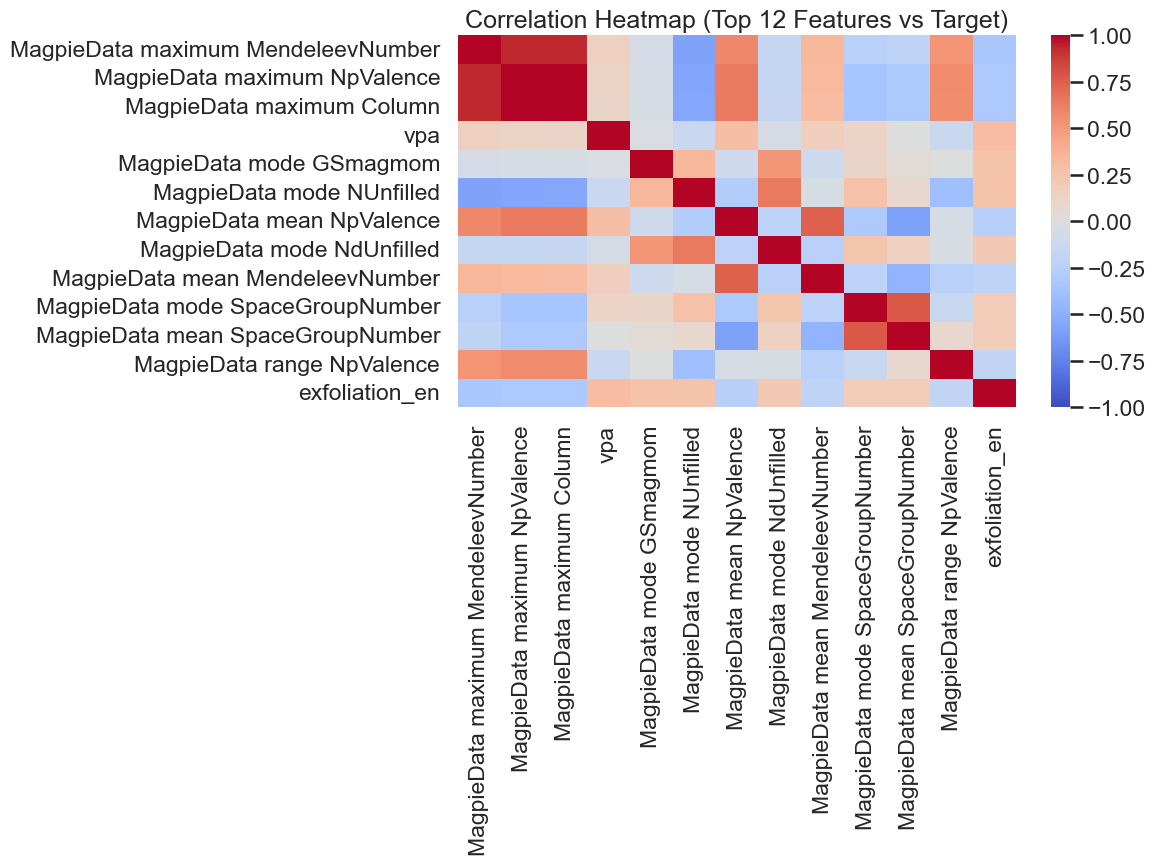

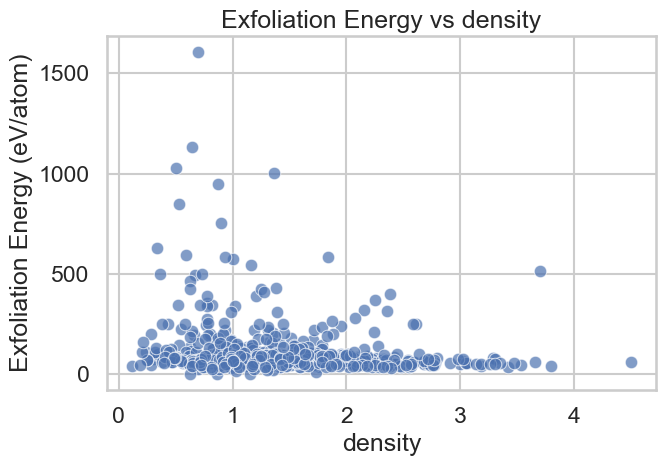

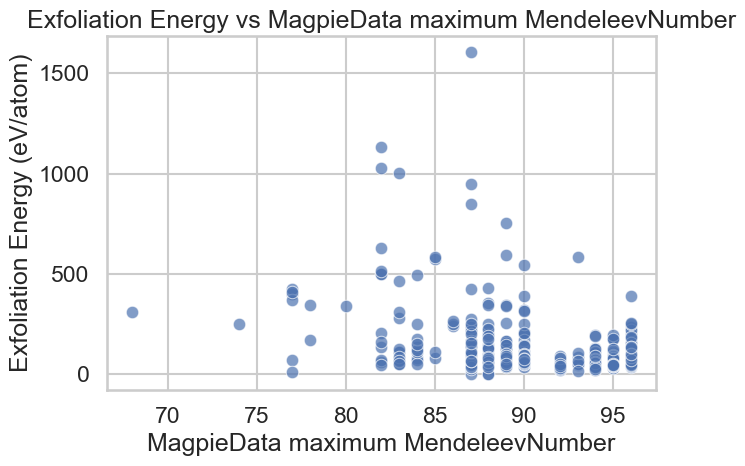

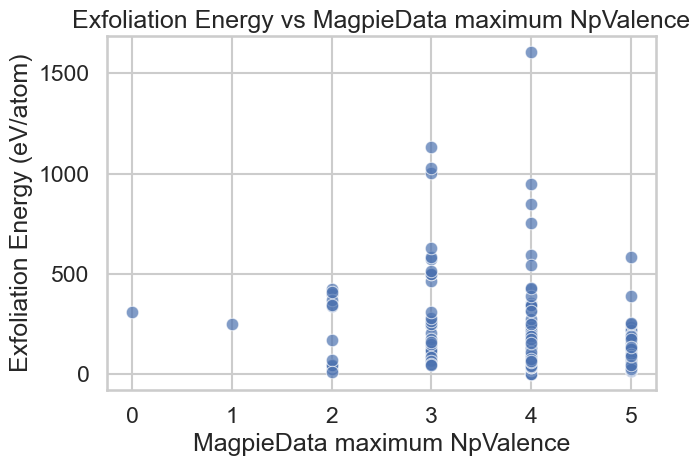

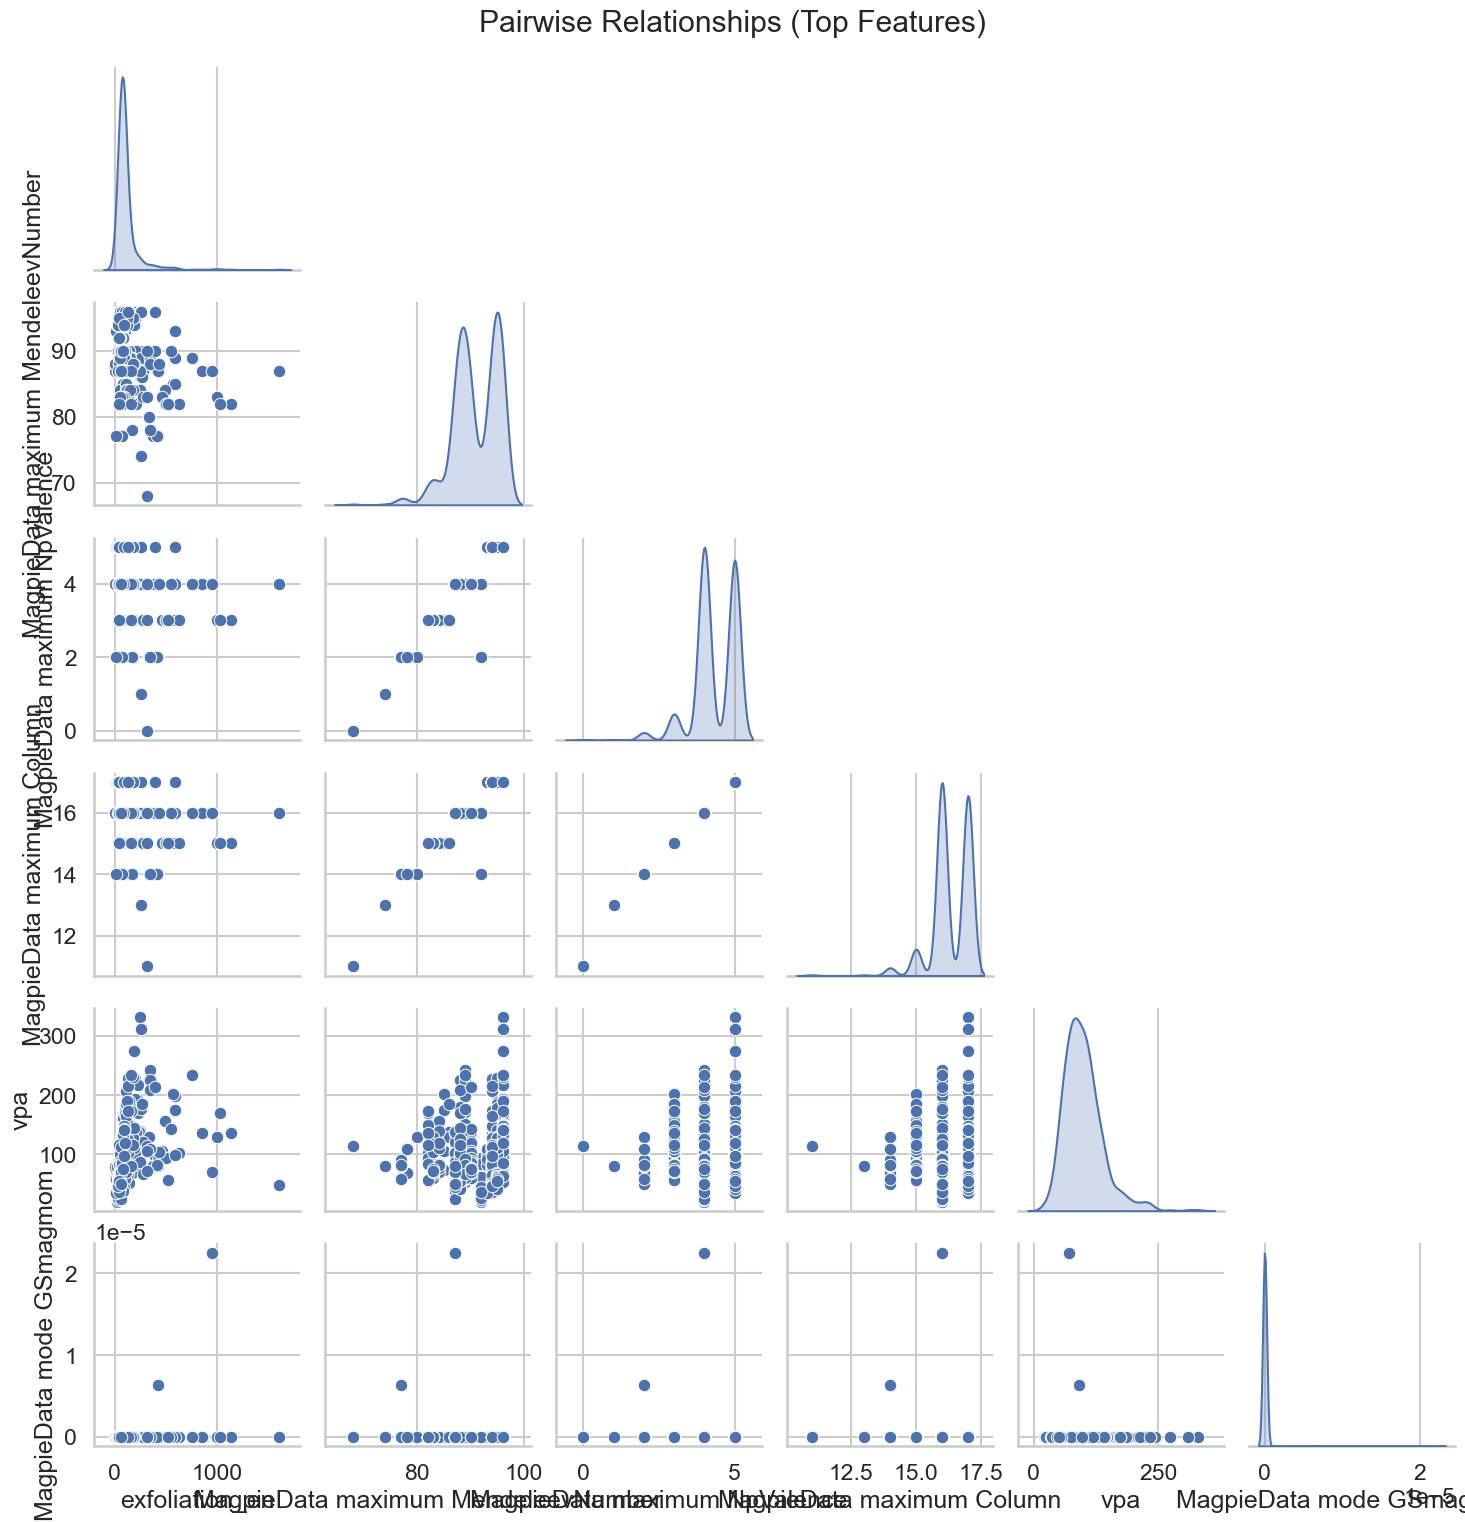

In [3]:
# ===============================================================
# PART B2: Exploratory Data Analysis
# ===============================================================

# --- 1. Distribution of target ---
plt.figure(figsize=(7,5))
sns.histplot(df_feat["exfoliation_en"], kde=True, color="royalblue")
plt.xlabel("Exfoliation Energy (eV/atom)")
plt.ylabel("Count")
plt.title("Distribution of Exfoliation Energy")
plt.tight_layout()
plt.savefig(FIG_DIR / "exfoliation_distribution.png", dpi=300)
plt.show()

# --- 2. Correlation heatmap (top correlated features) ---
corr = df_feat.corr(numeric_only=True)
target_corr = corr["exfoliation_en"].drop("exfoliation_en").abs().sort_values(ascending=False)
top_feats = list(target_corr.head(12).index) + ["exfoliation_en"]

plt.figure(figsize=(12,9))
sns.heatmap(df_feat[top_feats].corr(), cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Top 12 Features vs Target)")
plt.tight_layout()
plt.savefig(FIG_DIR / "feature_correlation_heatmap.png", dpi=300)
plt.show()

# --- 3. Scatterplots with top features ---
for f in ["density"] + list(target_corr.head(2).index):
    if f not in df_feat.columns: 
        continue
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=df_feat[f], y=df_feat["exfoliation_en"], alpha=0.7)
    plt.xlabel(f)
    plt.ylabel("Exfoliation Energy (eV/atom)")
    plt.title(f"Exfoliation Energy vs {f}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"exfoliation_vs_{f}.png", dpi=300)
    plt.show()

# --- 4. Pairplot overview (target + 5 strongest features) ---
pair_cols = ["exfoliation_en"] + list(target_corr.head(5).index)
sns.pairplot(df_feat[pair_cols], corner=True, diag_kind="kde")
plt.suptitle("Pairwise Relationships (Top Features)", y=1.02)
plt.savefig(FIG_DIR / "pairwise_features.png", dpi=300)
plt.show()

CV MAE:  73.537 ± 8.542
CV RMSE: 130.625 ± 26.520
Test MAE: 61.681 eV/atom
Test RMSE: 92.576 eV/atom


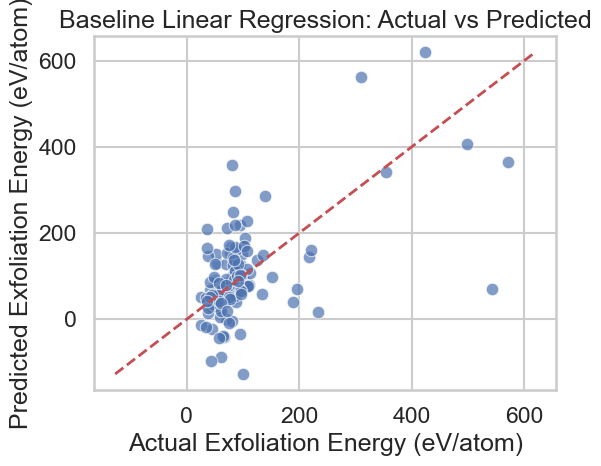

In [4]:
# ===============================================================
# PART B3: Baseline Model – Linear Regression
# ===============================================================

X = df_feat.drop(columns=["exfoliation_en"])
y = df_feat["exfoliation_en"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaled pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = -cross_val_score(pipe, X, y, scoring="neg_mean_absolute_error", cv=cv)
cv_rmse = np.sqrt(-cross_val_score(pipe, X, y, scoring="neg_mean_squared_error", cv=cv))
print(f"CV MAE:  {cv_mae.mean():.3f} ± {cv_mae.std():.3f}")
print(f"CV RMSE: {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")

# Train/test metrics
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE: {mae:.3f} eV/atom")
print(f"Test RMSE: {rmse:.3f} eV/atom")

# --- Actual vs Predicted ---
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.xlabel("Actual Exfoliation Energy (eV/atom)")
plt.ylabel("Predicted Exfoliation Energy (eV/atom)")
plt.title("Baseline Linear Regression: Actual vs Predicted")
plt.tight_layout()
plt.savefig(FIG_DIR / "baseline_actual_vs_predicted.png", dpi=300)
plt.show()